# Лабораторная работа №1

In [19]:
# Loading extension for reloading editable packages (pip install -e .)
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# Reloading editable packages.
%autoreload
# from lab1.main import get_results

Вариант для задания №3:
1. Номер группы + 15 = 2 + 15 = 17
2. Номер варианта + 56 = 14 + 56 = 70
3. ИУ5 (Номер варианта + 21) = 14 + 21 = 35

In [36]:
import pickle
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from numpy.typing import ArrayLike
from PIL import Image
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, TensorDataset

%matplotlib inline

## Часть 1. Задача регрессии по теореме универсальной аппроксимации, ручное дифференцирование
Генерация выборки и инициализация параметров нейронной сети

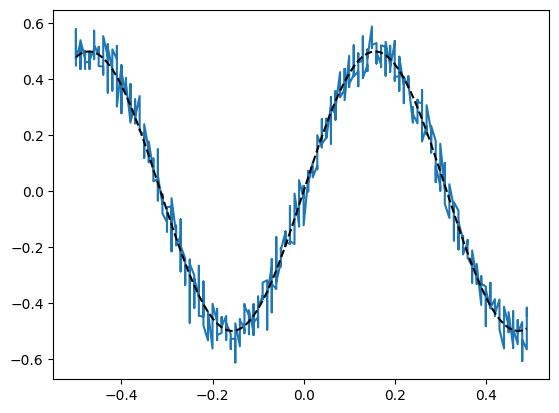

In [22]:
from operator import itemgetter  # noqa

X = (np.arange(100) / 100 - 0.5).repeat(5)
# Наша функция, которую мы пытаемся получить в ходе апроксимации.
# y = 1 / (1 + np.exp(-10 * X))  # Исходная.
y = np.sin(X * 10) / 2
yn = np.random.normal(scale=0.05, size=y.size) + y

plt.plot(X, yn)
plt.plot(X, y, linestyle="--", c="k")
################################################

HIDDEN_SIZE = 64


# size = 1 for regression, size = number of classes for classification.
def np_to_tensor(arr: ArrayLike, size=1):
    return torch.Tensor(arr.reshape(-1, size))


tensor_X = np_to_tensor(X)
tensor_y = np_to_tensor(yn)


# Инициализация весов MLP с одним скрытым слоём
def init_neural_network(hidden_size=HIDDEN_SIZE):
    weights1 = (torch.rand(1, hidden_size) - 0.5) / 10
    bias1 = torch.zeros(hidden_size)

    weights2 = (torch.rand(hidden_size, 1) - 0.5) / 10
    bias2 = torch.zeros(1)

    return {"weights1": weights1, "bias1": bias1, "weights2": weights2, "bias2": bias2}


weights1, bias1, weights2, bias2 = itemgetter("weights1", "bias1", "weights2", "bias2")(
    init_neural_network()
)

### Обучение нейронной сети задачи регрессии

0.0046781674


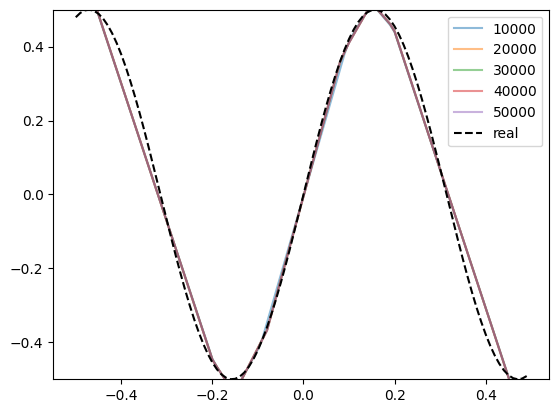

In [23]:
# Определяем функцию нелинйности
def relu(x: torch.Tensor):
    return torch.maximum(x, torch.Tensor([0]))


# Прямой проход
def forward(x: torch.Tensor) -> torch.Tensor:
    return (weights2.t() * relu((weights1 * x) + bias1)).sum(
        axis=-1, keepdims=True
    ) + bias2


def loss(y: torch.Tensor, y_: torch.Tensor) -> torch.Tensor:
    return ((y - y_) ** 2).sum(axis=-1)


# обратный проход
def backward(X: torch.Tensor, y: torch.Tensor, y_pred: torch.Tensor):
    # производная функции потерь по y_pred
    dL = 2 * (y_pred - y)
    # значения нейронов скрытго слоя до применения активации
    Ax = (weights1 * X) + bias1
    # значения нейронов скрытого слоя после применения активации
    A = relu(Ax)
    # производная функции потерь по weight_2
    dW2 = torch.mm(A.t(), dL)
    # производная функции потерь по bias_2
    db2 = dL.sum(axis=0)
    # производная функции потерь по значениям скрытого слоя после активации
    dA = torch.mm(dL, weights2.t())
    # производная функции потерь по значениям скрытого слоя до активации
    dA[Ax <= 0] = 0
    # производная функции потерь по weight_1
    dW1 = torch.mm(X.t(), dA)
    # производная функции потерь по bias_1
    db1 = dA.sum(axis=0)
    # print(dW.shape, db.shape, dW2.shape, db2.shape)

    return {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}


def optimize(params, grads, lr=0.001):
    # градиентный спуск по всей обучающей выборке
    W1, b1, W2, b2 = params
    W1 -= lr * grads["dW1"]
    W2 -= lr * grads["dW2"]
    b1 -= lr * grads["db1"]
    b2 -= lr * grads["db2"]

    return {"W1": W1, "b1": b1, "W2": W2, "b2": b2}


# 50 тысяч итераций градиентного спуска == 50 тысяч эпох
for i in range(50000):
    output = forward(tensor_X)
    cur_loss = loss(output, tensor_y)
    grads = backward(tensor_X, tensor_y, output)
    params = [weights1, bias1, weights2, bias2]
    optimized_params = optimize(params, grads, 1e-4)
    weights1, bias1, weights2, bias2 = itemgetter("W1", "b1", "W2", "b2")(
        optimized_params
    )

    if (i + 1) % 10000 == 0:
        plt.plot(X, output.numpy(), label=str(i + 1), alpha=0.5)

plt.plot(X, y, linestyle="--", c="k", label="real")
plt.legend()
plt.ylim(y.min(), y.max())
print(cur_loss.numpy().mean())

## Часть 2. Бинарная классификация с помощью автодиффиренцирования PyTorch
Генерация выборки и инициализация параметров нейронной сети

In [24]:
def demonstrate_dataset(X: ArrayLike, y: ArrayLike):
    plt.scatter(X[:, 0], X[:, 1], c=y)

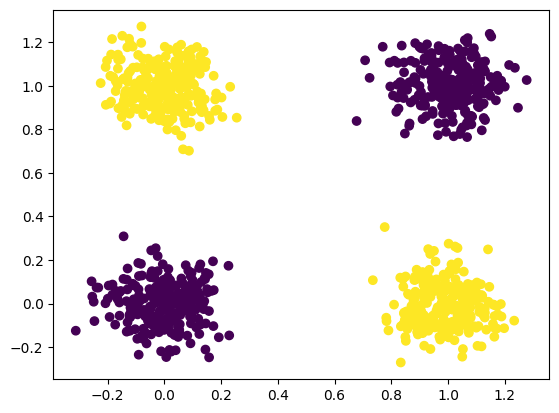

In [25]:
# Данные, которые стараемся классифицировать:
X_xor = np.random.randint(2, size=(1000, 2))
y_xor = (X_xor[:, 0] + X_xor[:, 1]) % 2  # XOR
X_xor = X_xor + np.random.normal(0, scale=0.1, size=X_xor.shape)

demonstrate_dataset(X_xor, y_xor)

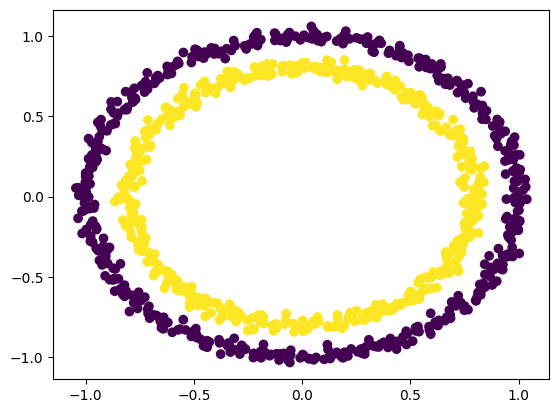

In [26]:
from sklearn.datasets import make_circles  # noqa

# Кольца, вложенные друг в друга.
X_cirles, y_circles = make_circles(n_samples=1000, noise=0.025)

demonstrate_dataset(X_cirles, y_circles)

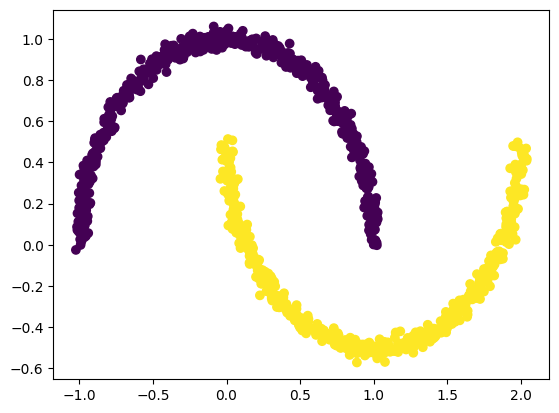

In [27]:
from sklearn.datasets import make_moons  # noqa

# Вложенные друг в друга месяцы.
X_moons, y_moons = make_moons(n_samples=1000, noise=0.025)

demonstrate_dataset(X_moons, y_moons)

In [28]:
HIDDEN_SIZE = 48


@dataclass()
class NeuralNetwork:
    def __init__(self, X: ArrayLike, y: ArrayLike, hidden_size=HIDDEN_SIZE):
        self.tensor_X = np_to_tensor(X, size=2)
        self.tensor_y = np_to_tensor(y)

        self.hidden_size = hidden_size
        self.weights1, self.bias1, self.weights2, self.bias2 = itemgetter(
            "weights1", "bias1", "weights2", "bias2"
        )(self.init_neural_network(hidden_size=hidden_size))

    # Инициализация весов MLP с одним скрытым слоём
    def init_neural_network(self, hidden_size):
        weights1 = (
            ((torch.rand(2, hidden_size) - 0.5) / 10).detach().requires_grad_(True)
        )
        bias1 = torch.zeros(hidden_size, requires_grad=True)

        weights2 = (
            ((torch.rand(hidden_size, 1) - 0.5) / 10).detach().requires_grad_(True)
        )
        bias2 = torch.zeros(1, requires_grad=True)

        return {
            "weights1": weights1,
            "bias1": bias1,
            "weights2": weights2,
            "bias2": bias2,
        }

    # Определяем функцию нелинейности
    def sigmoid(self, x: torch.Tensor):
        return 1 / (1 + torch.exp(-x))

    # Прямой проход
    def forward(self, x: torch.Tensor):
        hidden = torch.mm(x, self.weights1) + self.bias1
        hidden_nonlin = self.sigmoid(hidden)
        output = (self.weights2.t() * hidden_nonlin).sum(
            axis=-1, keepdims=True
        ) + self.bias2

        return self.sigmoid(output)

    # Logloss
    def loss(self, y_true: torch.Tensor, y_pred: torch.Tensor):
        return (
            -1
            * (y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred)).sum()
        )

    # lr - шаг обучения
    def model(self, learning_rate=1e-3, iterations=10_000):
        params = [self.weights1, self.bias1, self.weights2, self.bias2]
        losses = []
        for _ in range(iterations):
            output = self.forward(self.tensor_X)
            lossval = self.loss(self.tensor_y, output)
            lossval.backward()  # тут включается в работу autograd
            for w in params:
                with torch.no_grad():
                    w -= w.grad * learning_rate  # обновляем веса
                w.grad.zero_()  # зануляем градиенты, чтобы не накапливались за итерации
            losses.append(lossval.item())

        self.learning_results = {"losses": losses, "output": output}

        return self.learning_results


classificationNN = NeuralNetwork(X_xor, y_xor)

### Обучение нейронной сети задачи классификации

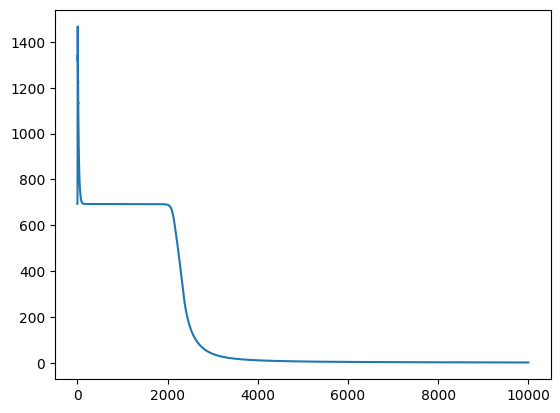

In [29]:
learning_results = classificationNN.model()
# выводим историю функции потерь по итерациям
plt.plot(learning_results["losses"])

### Проверка результатов обучения

(36481, 2)


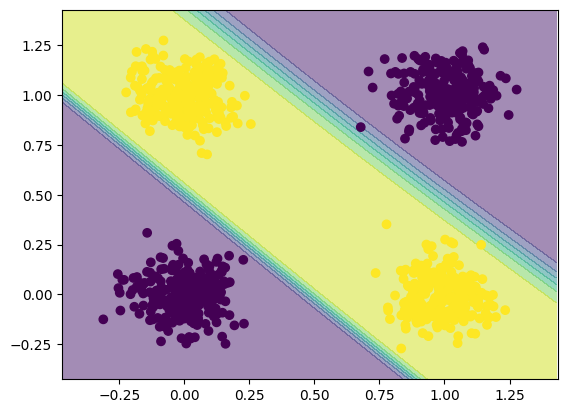

In [30]:
def plot_classification_results(data: torch.Tensor, neural_model: NeuralNetwork):
    x_coordinates = data[:, 0]
    y_coordinates = data[:, 1]
    x_coordinates_diff = x_coordinates.max() - x_coordinates.min()
    y_coordinates_diff = y_coordinates.max() - y_coordinates.min()
    left_boundary = x_coordinates.min() - 0.1 * x_coordinates_diff
    right_boundary = x_coordinates.max() + 0.1 * x_coordinates_diff
    bottom_boundary = y_coordinates.min() - 0.1 * y_coordinates_diff
    top_boundary = y_coordinates.max() + 0.1 * y_coordinates_diff

    grid = np.arange(left_boundary, right_boundary, 0.01)
    grid_width = grid.size
    surface = []
    # создаем точки по сетке
    for x1 in grid:
        for x2 in grid:
            surface.append((x1, x2))
    surface = np.array(surface)
    print(surface.shape)
    # получаем предсказания для всех точек плоскости, модель по уже полученным
    # весам пытается определить, какому классу принадлежит точка.
    with torch.no_grad():
        Z = neural_model.forward(torch.Tensor(surface)).detach().numpy()
    # меняем форму в виде двухмерного массива
    Z = Z.reshape(grid_width, grid_width)
    xx = surface[:, 0].reshape(grid_width, grid_width)
    yy = surface[:, 1].reshape(grid_width, grid_width)
    # рисуем разделяющие поверхности классов
    plt.contourf(xx, yy, Z, alpha=0.5)
    # рисуем обучающую выборку
    plt.scatter(
        x_coordinates,
        y_coordinates,
        c=neural_model.learning_results["output"].detach().numpy() > 0.5,
    )
    # задаём границы отображения графика
    plt.xlim(left_boundary, right_boundary)
    plt.ylim(bottom_boundary, top_boundary)


plot_classification_results(X_xor, classificationNN)

hidden_size = 16
(63001, 2)


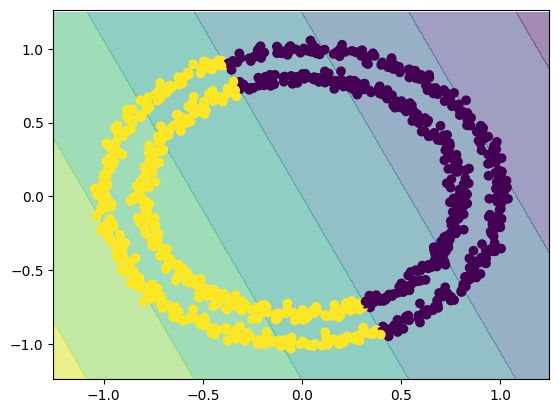

hidden_size = 32
(63001, 2)


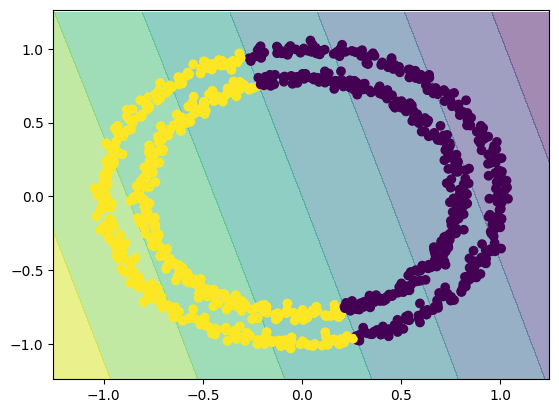

hidden_size = 48
(63001, 2)


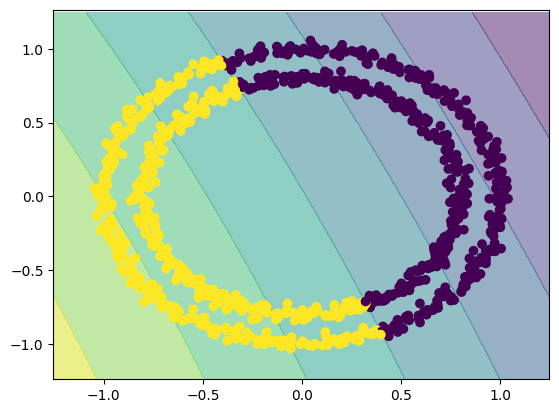

hidden_size = 64
(63001, 2)


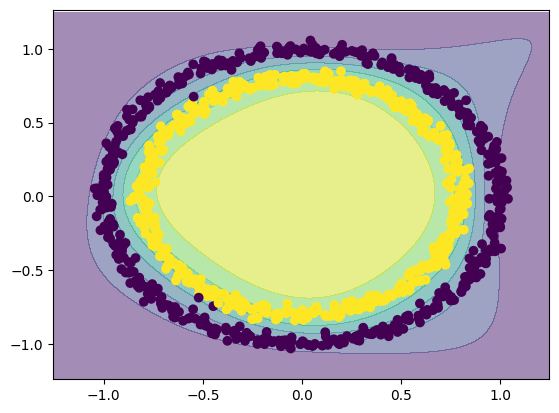

hidden_size = 80
(63001, 2)


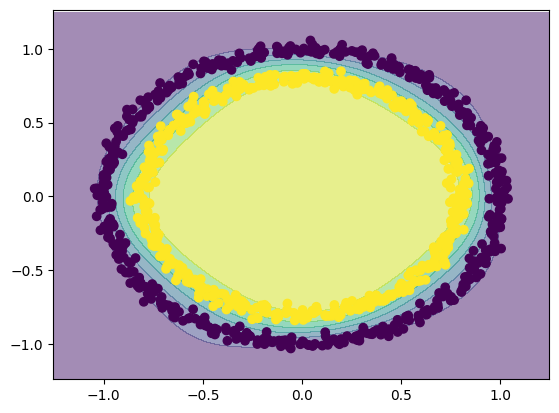

In [31]:
for hidden_size in [16, 32, 48, 64, 80]:
    print(f"{hidden_size = }")
    classificationNN = NeuralNetwork(X_cirles, y_circles, hidden_size)
    classificationNN.model()
    plt.figure()
    plot_classification_results(X_cirles, classificationNN)
    plt.show()

hidden_size = 16
(135424, 2)


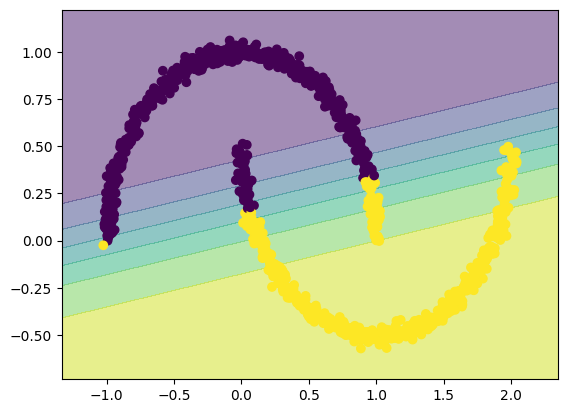

hidden_size = 32
(135424, 2)


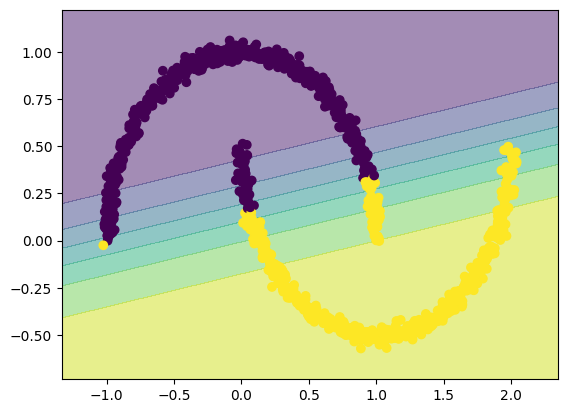

hidden_size = 48
(135424, 2)


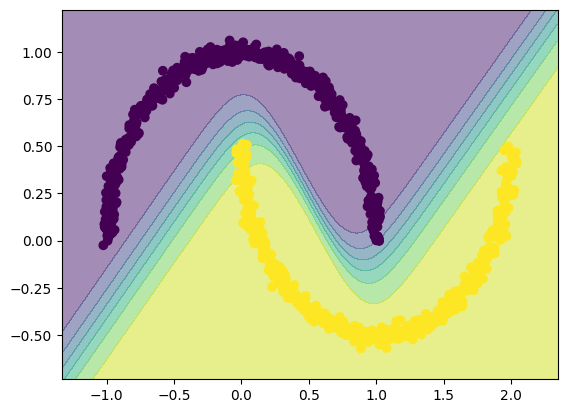

hidden_size = 64
(135424, 2)


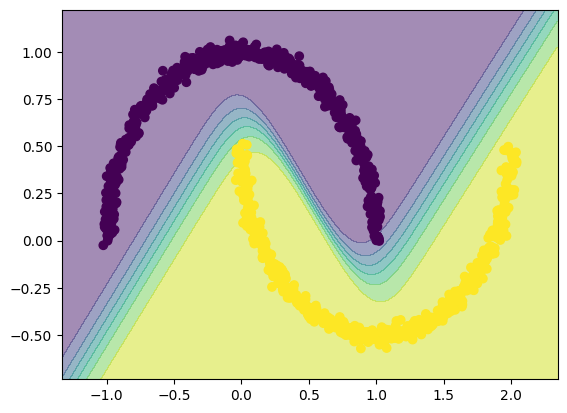

hidden_size = 80
(135424, 2)


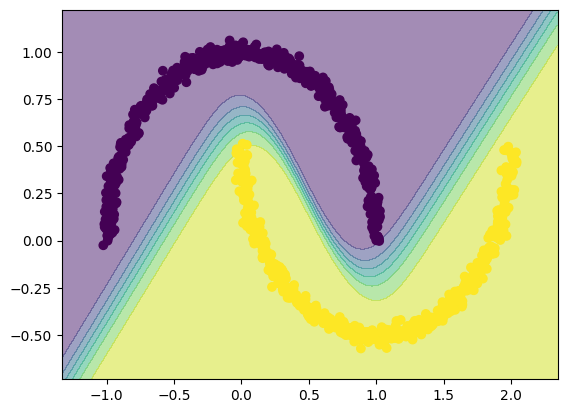

In [32]:
for hidden_size in [16, 32, 48, 64, 80]:
    print(f"{hidden_size = }")
    classificationNN = NeuralNetwork(X_moons, y_moons, hidden_size)
    classificationNN.model()
    plt.figure()
    plot_classification_results(X_moons, classificationNN)
    plt.show()

### Вывод
Наша нейронная сеть с 16 нейронами в скрытом слое справилась с классификацией XOR.
Для колец понадобилось увеличить количество нейронов до 80. Для лун - до 48.

## Часть 3. Классификация изображений CIFAR100
### Загрузка и распаковка набора данных CIFAR100

In [33]:
import os
import shutil
import urllib
from pathlib import Path

url = "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"
filename = "cifar-100-python.tar.gz"
data_path = Path("data")

data_path.mkdir(exist_ok=True)

file_path = data_path / filename

if not os.path.isfile(file_path):
    urllib.request.urlretrieve(url, file_path)
    shutil.unpack_archive(file_path, extract_dir=data_path)
    file_path.unlink()  # Remove archive after extracting it.

### Чтение тренировочной и тестовой выборки

In [34]:
def stem_extensions(filename: Path):
    extensions = "".join(filename.suffixes)

    return str(filename).removesuffix(extensions)

In [37]:
dataset_path = Path(stem_extensions(file_path))

with open(dataset_path / "train", "rb") as f:
    data_train = pickle.load(f, encoding="latin1")
with open(dataset_path / "test", "rb") as f:
    data_test = pickle.load(f, encoding="latin1")

# Классы по варианту.
CLASSES = [17, 70, 35]

train_X_raw = data_train["data"].reshape(-1, 3, 32, 32)
train_X_raw = np.transpose(train_X_raw, [0, 2, 3, 1])  # NCHW -> NHWC
train_y_raw = np.array(data_train["fine_labels"])
mask = np.isin(train_y_raw, CLASSES)
train_X = train_X_raw[mask].copy()
train_y = train_y_raw[mask].copy()
train_y = np.unique(train_y, return_inverse=1)[1]
del data_train

test_X = data_test["data"].reshape(-1, 3, 32, 32)
test_X = np.transpose(test_X, [0, 2, 3, 1])
test_y = np.array(data_test["fine_labels"])
mask = np.isin(test_y, CLASSES)
test_X = test_X[mask].copy()
test_y = test_y[mask].copy()
test_y = np.unique(test_y, return_inverse=1)[1]
del data_test

# print(train_y_raw.tolist())

In [38]:
def createImage(data: ArrayLike):
    return Image.fromarray(data).resize((256, 256))

In [39]:
# Source: https://stackoverflow.com/a/47334314
def grid_display(list_of_images, list_of_titles=[], no_of_columns=2, figsize=(10, 10)):
    fig = plt.figure(figsize=figsize)
    column = 0
    for i in range(len(list_of_images)):
        column += 1
        #  check for end of column and create a new figure
        if column == no_of_columns + 1:
            fig = plt.figure(figsize=figsize)
            column = 1
        fig.add_subplot(1, no_of_columns, column)
        plt.imshow(list_of_images[i])
        plt.axis("off")
        if len(list_of_titles) >= len(list_of_images):
            plt.title(list_of_titles[i])

class_id = 17:


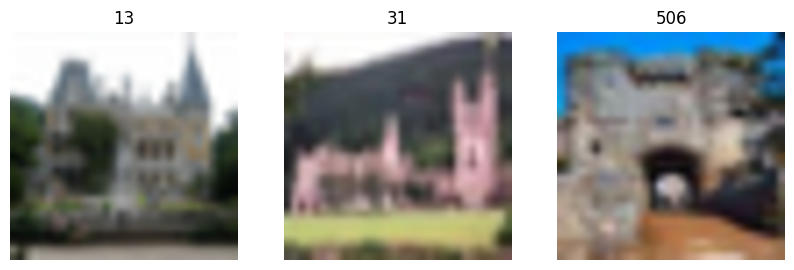

class_id = 70:


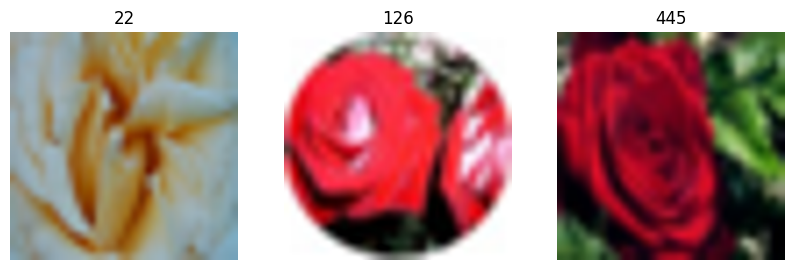

class_id = 35:


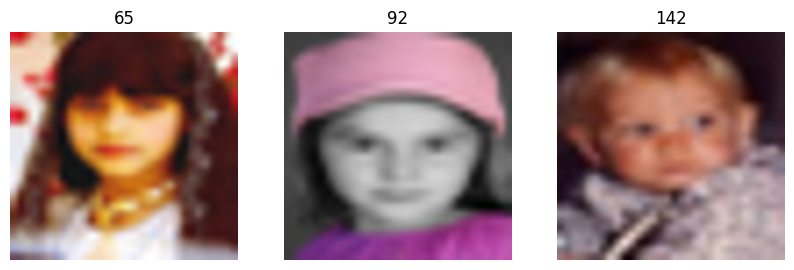

In [40]:
# По 3 экземпляра класса из выборки.
number_of_images_per_class_to_show = 3

for class_id in CLASSES:
    print(f"{class_id = }:")
    i = number_of_images_per_class_to_show
    image_index_for_class = -1
    class_images = []
    image_indices = []

    while i > 0:
        image_index_for_class = train_y_raw.tolist().index(
            class_id, image_index_for_class + 1
        )
        image_indices.append(image_index_for_class)
        class_images.append(createImage(train_X_raw[image_index_for_class]))
        i -= 1
    grid_display(class_images, image_indices, number_of_images_per_class_to_show)
    plt.show()

### Создание Pytorch DataLoader'a

In [41]:
def create_dataloader(batch_size=128):
    dataloader: dict[str, DataLoader] = {}
    for (X, y), part in zip([(train_X, train_y), (test_X, test_y)], ["train", "test"]):
        tensor_x = torch.Tensor(X)
        tensor_y = (
            F.one_hot(torch.Tensor(y).to(torch.int64), num_classes=len(CLASSES)) / 1.0
        )
        dataset = TensorDataset(tensor_x, tensor_y)  # создание объекта датасета
        dataloader[part] = DataLoader(
            dataset, batch_size=batch_size, shuffle=True
        )  # создание экземпляра класса DataLoader

    return dataloader

### Создание Pytorch модели многослойного перцептрона с одним скрытым слоем

In [42]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def forward(self, input):
        x = input / 255.0
        x = x - self.mean
        x = x / self.std

        return torch.flatten(x, start_dim=1)  # nhwc -> nm


class Cifar100_MLP(nn.Module):
    def __init__(self, hidden_size=32, classes=100):
        super(Cifar100_MLP, self).__init__()
        # https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
        self.norm = Normalize([0.5074, 0.4867, 0.4411], [0.2011, 0.1987, 0.2025])
        self.seq = nn.Sequential(
            nn.Linear(32 * 32 * 3, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, classes),
        )

    def forward(self, input):
        x = self.norm(input)

        return self.seq(x)


HIDDEN_SIZE = 10
model = Cifar100_MLP(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
model

Cifar100_MLP(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=3, bias=True)
  )
)

### Обучение модели по эпохам

In [43]:
EPOCHS = 250


def train(
    model: nn.Module,
    criterion: nn.CrossEntropyLoss,
    optimizer: optim.Optimizer,
    dataloader: dict[str, DataLoader],
    epochs=EPOCHS,
):
    steps_per_epoch = len(dataloader["train"])
    steps_per_epoch_val = len(dataloader["test"])

    for epoch in range(epochs):  # проход по набору данных несколько раз
        running_loss = 0.0
        model.train()
        for i, batch in enumerate(dataloader["train"], 0):
            # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
            inputs, labels = batch

            # очищение прошлых градиентов с прошлой итерации
            optimizer.zero_grad()

            # прямой + обратный проходы + оптимизация
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            # loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()

            # для подсчёта статистик
            running_loss += loss.item()
        print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / steps_per_epoch:.3f}")
        running_loss = 0.0
        model.eval()
        with torch.no_grad():  # отключение автоматического дифференцирования
            for i, data in enumerate(dataloader["test"], 0):
                inputs, labels = data

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
        print(
            f"[{epoch + 1}, {i + 1:5d}] val loss: {running_loss / steps_per_epoch_val:.3f}"
        )
    print("Обучение закончено")

    return dataloader

### Выбор функции потерь и оптимизатора градиентного спуска

In [44]:
def train_classifier(
    model: nn.Module, learning_rate=0.005, batch_size=128, epochs=EPOCHS
):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    dataloader = create_dataloader(batch_size=batch_size)

    return train(
        model,
        criterion=criterion,
        optimizer=optimizer,
        dataloader=dataloader,
        epochs=epochs,
    )


dataloader = train_classifier(model)

[1,    12] loss: 0.831
[1,     3] val loss: 0.651
[2,    12] loss: 0.657
[2,     3] val loss: 0.612
[3,    12] loss: 0.601
[3,     3] val loss: 0.560
[4,    12] loss: 0.569
[4,     3] val loss: 0.549
[5,    12] loss: 0.544
[5,     3] val loss: 0.559
[6,    12] loss: 0.528
[6,     3] val loss: 0.479
[7,    12] loss: 0.512
[7,     3] val loss: 0.534
[8,    12] loss: 0.499
[8,     3] val loss: 0.493
[9,    12] loss: 0.489
[9,     3] val loss: 0.483
[10,    12] loss: 0.475
[10,     3] val loss: 0.437
[11,    12] loss: 0.465
[11,     3] val loss: 0.473
[12,    12] loss: 0.457
[12,     3] val loss: 0.460
[13,    12] loss: 0.445
[13,     3] val loss: 0.471
[14,    12] loss: 0.436
[14,     3] val loss: 0.441
[15,    12] loss: 0.427
[15,     3] val loss: 0.455
[16,    12] loss: 0.419
[16,     3] val loss: 0.437
[17,    12] loss: 0.416
[17,     3] val loss: 0.417
[18,    12] loss: 0.406
[18,     3] val loss: 0.442
[19,    12] loss: 0.399
[19,     3] val loss: 0.437
[20,    12] loss: 0.395
[20,  

[160,     3] val loss: 0.394
[161,    12] loss: 0.086
[161,     3] val loss: 0.444
[162,    12] loss: 0.086
[162,     3] val loss: 0.422
[163,    12] loss: 0.084
[163,     3] val loss: 0.394
[164,    12] loss: 0.083
[164,     3] val loss: 0.409
[165,    12] loss: 0.083
[165,     3] val loss: 0.416
[166,    12] loss: 0.083
[166,     3] val loss: 0.444
[167,    12] loss: 0.081
[167,     3] val loss: 0.409
[168,    12] loss: 0.081
[168,     3] val loss: 0.438
[169,    12] loss: 0.080
[169,     3] val loss: 0.440
[170,    12] loss: 0.081
[170,     3] val loss: 0.379
[171,    12] loss: 0.078
[171,     3] val loss: 0.473
[172,    12] loss: 0.077
[172,     3] val loss: 0.418
[173,    12] loss: 0.076
[173,     3] val loss: 0.493
[174,    12] loss: 0.076
[174,     3] val loss: 0.461
[175,    12] loss: 0.076
[175,     3] val loss: 0.440
[176,    12] loss: 0.074
[176,     3] val loss: 0.417
[177,    12] loss: 0.074
[177,     3] val loss: 0.476
[178,    12] loss: 0.074
[178,     3] val loss: 0.388

### Проверка качества модели по классам на обучающей и тестовой выборках

In [45]:
def report_classification_results(dataloader: DataLoader):
    y_pred = []
    y_true = []
    with torch.no_grad():  # отключение автоматического дифференцирования
        for _, data in enumerate(dataloader, 0):
            inputs, labels = data

            outputs = model(inputs).detach().numpy()
            y_pred.append(outputs)
            y_true.append(labels.numpy())
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        print(
            classification_report(
                y_true.argmax(axis=-1),
                y_pred.argmax(axis=-1),
                digits=4,
                target_names=list(map(str, CLASSES)),
            )
        )

In [46]:
def compare_classification_reports(dataloader: dict[str, DataLoader]):
    for part in ["train", "test"]:
        print(part)
        report_classification_results(dataloader[part])
        part != "test" and print("-" * 53)


compare_classification_reports(dataloader)

train
              precision    recall  f1-score   support

          17     0.9980    0.9980    0.9980       500
          70     0.9940    0.9980    0.9960       500
          35     0.9980    0.9940    0.9960       500

    accuracy                         0.9967      1500
   macro avg     0.9967    0.9967    0.9967      1500
weighted avg     0.9967    0.9967    0.9967      1500

-----------------------------------------------------
test
              precision    recall  f1-score   support

          17     0.9200    0.9200    0.9200       100
          70     0.8315    0.7400    0.7831       100
          35     0.7658    0.8500    0.8057       100

    accuracy                         0.8367       300
   macro avg     0.8391    0.8367    0.8363       300
weighted avg     0.8391    0.8367    0.8363       300



### Анализ результатов обучения модели
Как видно, лучше всего был предсказан класс с идентификатором 17, представляющий
собой замки. Вероятнее всего это связано с количеством общих уникальных черт объектов
на картинках: у замков их намного меньше по сравнению с, например, ребёнком,
который может быть разного возраста, расы и может быть одет по-разному.

На лицо так же переобучение: в обучающей выборке характеристики были почти идеальными,
а в тестовых данных для некоторых классов средними. Скорректируем параметры для устранения
этого феномена в надежде улучшить качество модели.

Уменьшим количество эпох.

In [47]:
model = Cifar100_MLP(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
dataloader = train_classifier(model, epochs=51)
compare_classification_reports(dataloader)

[1,    12] loss: 1.021
[1,     3] val loss: 0.911
[2,    12] loss: 0.844
[2,     3] val loss: 0.768
[3,    12] loss: 0.707
[3,     3] val loss: 0.633
[4,    12] loss: 0.624
[4,     3] val loss: 0.592
[5,    12] loss: 0.571
[5,     3] val loss: 0.564
[6,    12] loss: 0.534
[6,     3] val loss: 0.546
[7,    12] loss: 0.514
[7,     3] val loss: 0.501
[8,    12] loss: 0.488
[8,     3] val loss: 0.476
[9,    12] loss: 0.473
[9,     3] val loss: 0.456
[10,    12] loss: 0.458
[10,     3] val loss: 0.490
[11,    12] loss: 0.444
[11,     3] val loss: 0.454
[12,    12] loss: 0.434
[12,     3] val loss: 0.472
[13,    12] loss: 0.422
[13,     3] val loss: 0.407
[14,    12] loss: 0.413
[14,     3] val loss: 0.435
[15,    12] loss: 0.402
[15,     3] val loss: 0.447
[16,    12] loss: 0.396
[16,     3] val loss: 0.423
[17,    12] loss: 0.386
[17,     3] val loss: 0.423
[18,    12] loss: 0.379
[18,     3] val loss: 0.414
[19,    12] loss: 0.374
[19,     3] val loss: 0.430
[20,    12] loss: 0.366
[20,  

### Визуализация весов

In [ ]:
weights = list(model.parameters())[0].detach().numpy()
print(weights.shape)
fig, ax = plt.subplots(1, weights.shape[0], figsize=(3 * weights.shape[0], 3))
for i, ω in enumerate(weights):
    ω = ω.reshape(32, 32, 3)
    ω -= np.percentile(ω, 1, axis=[0, 1])
    ω /= np.percentile(ω, 99, axis=[0, 1])
    ω = np.clip(ω, 0, 1)
    ax[i].imshow(ω)

По логам потерь было выяснено, что переобучение для данной модели
начинается на 52 эпохах, поэтому оставим 51.

Изменим batch_size, сохраняя общее количество итераций. Для этого количество
эпох уменьшим в то же количество раз, во сколько увеличили batch_size.

In [48]:
model = Cifar100_MLP(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
dataloader = train_classifier(model, epochs=25, batch_size=256)
compare_classification_reports(dataloader)

[1,     6] loss: 0.926
[1,     2] val loss: 0.787
[2,     6] loss: 0.762
[2,     2] val loss: 0.665
[3,     6] loss: 0.686
[3,     2] val loss: 0.671
[4,     6] loss: 0.642
[4,     2] val loss: 0.652
[5,     6] loss: 0.611
[5,     2] val loss: 0.609
[6,     6] loss: 0.587
[6,     2] val loss: 0.612
[7,     6] loss: 0.569
[7,     2] val loss: 0.588
[8,     6] loss: 0.553
[8,     2] val loss: 0.596
[9,     6] loss: 0.542
[9,     2] val loss: 0.501
[10,     6] loss: 0.528
[10,     2] val loss: 0.499
[11,     6] loss: 0.516
[11,     2] val loss: 0.485
[12,     6] loss: 0.507
[12,     2] val loss: 0.497
[13,     6] loss: 0.499
[13,     2] val loss: 0.500
[14,     6] loss: 0.491
[14,     2] val loss: 0.555
[15,     6] loss: 0.483
[15,     2] val loss: 0.437
[16,     6] loss: 0.476
[16,     2] val loss: 0.503
[17,     6] loss: 0.469
[17,     2] val loss: 0.457
[18,     6] loss: 0.463
[18,     2] val loss: 0.518
[19,     6] loss: 0.456
[19,     2] val loss: 0.438
[20,     6] loss: 0.449
[20,  

Общие метрики модели на тестовой выборке не сильно поменялись, однако
отношение значений обучающий к тестовой выборке очень близко к 1. Можно
с уверенностью сказать, что на данном этапе переобучения не наблюдается.

Постараемся ещё улучшить модель:
уменьшим скорость обучения и увеличим общее количество итераций.

Для уменьшенной в два раза скорости обучения, переобучение началось в районе
78-79 эпох. Поставив 77 эпохи мы достигли точности:

In [49]:
model = Cifar100_MLP(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
dataloader = train_classifier(model, learning_rate=0.0025, epochs=77, batch_size=256)
compare_classification_reports(dataloader)

[1,     6] loss: 1.061
[1,     2] val loss: 0.884
[2,     6] loss: 0.899
[2,     2] val loss: 0.886
[3,     6] loss: 0.849
[3,     2] val loss: 0.809
[4,     6] loss: 0.817
[4,     2] val loss: 0.790
[5,     6] loss: 0.792
[5,     2] val loss: 0.756
[6,     6] loss: 0.771
[6,     2] val loss: 0.752
[7,     6] loss: 0.752
[7,     2] val loss: 0.717
[8,     6] loss: 0.734
[8,     2] val loss: 0.747
[9,     6] loss: 0.717
[9,     2] val loss: 0.705
[10,     6] loss: 0.703
[10,     2] val loss: 0.662
[11,     6] loss: 0.688
[11,     2] val loss: 0.691
[12,     6] loss: 0.674
[12,     2] val loss: 0.657
[13,     6] loss: 0.660
[13,     2] val loss: 0.631
[14,     6] loss: 0.644
[14,     2] val loss: 0.627
[15,     6] loss: 0.632
[15,     2] val loss: 0.628
[16,     6] loss: 0.618
[16,     2] val loss: 0.585
[17,     6] loss: 0.604
[17,     2] val loss: 0.553
[18,     6] loss: 0.591
[18,     2] val loss: 0.573
[19,     6] loss: 0.578
[19,     2] val loss: 0.618
[20,     6] loss: 0.566
[20,  

Поменяем количество нейронов в скрытом слое. Так как модель из-за этого
значительно поменяем, подстроим остальные гиперпараметры для устранения
переобучения и постараемся найти максимум, которого может достигичь модель.

In [50]:
model = Cifar100_MLP(hidden_size=2 * HIDDEN_SIZE, classes=len(CLASSES))
dataloader = train_classifier(model, learning_rate=0.0025, epochs=88, batch_size=256)
compare_classification_reports(dataloader)

[1,     6] loss: 1.063
[1,     2] val loss: 0.964
[2,     6] loss: 0.912
[2,     2] val loss: 0.864
[3,     6] loss: 0.821
[3,     2] val loss: 0.731
[4,     6] loss: 0.758
[4,     2] val loss: 0.676
[5,     6] loss: 0.711
[5,     2] val loss: 0.691
[6,     6] loss: 0.674
[6,     2] val loss: 0.637
[7,     6] loss: 0.643
[7,     2] val loss: 0.568
[8,     6] loss: 0.620
[8,     2] val loss: 0.640
[9,     6] loss: 0.600
[9,     2] val loss: 0.605
[10,     6] loss: 0.582
[10,     2] val loss: 0.525
[11,     6] loss: 0.566
[11,     2] val loss: 0.576
[12,     6] loss: 0.551
[12,     2] val loss: 0.544
[13,     6] loss: 0.539
[13,     2] val loss: 0.471
[14,     6] loss: 0.528
[14,     2] val loss: 0.486
[15,     6] loss: 0.518
[15,     2] val loss: 0.481
[16,     6] loss: 0.508
[16,     2] val loss: 0.517
[17,     6] loss: 0.500
[17,     2] val loss: 0.480
[18,     6] loss: 0.493
[18,     2] val loss: 0.487
[19,     6] loss: 0.486
[19,     2] val loss: 0.484
[20,     6] loss: 0.478
[20,  

Добавим ещё один скрытый слой.

In [51]:
class Cifar100_MLP_2(nn.Module):
    def __init__(self, hidden_sizes=[32, 26], classes=100):
        super(Cifar100_MLP_2, self).__init__()
        # https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
        self.norm = Normalize([0.5074, 0.4867, 0.4411], [0.2011, 0.1987, 0.2025])
        self.seq = nn.Sequential(
            nn.Linear(32 * 32 * 3, hidden_sizes[0]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[1], classes),
        )

    def forward(self, input):
        x = self.norm(input)

        return self.seq(x)

In [52]:
model = Cifar100_MLP_2(classes=len(CLASSES))
dataloader = train_classifier(model, learning_rate=0.0025, epochs=233, batch_size=256)
compare_classification_reports(dataloader)

[1,     6] loss: 1.095
[1,     2] val loss: 1.069
[2,     6] loss: 1.046
[2,     2] val loss: 1.027
[3,     6] loss: 1.010
[3,     2] val loss: 1.006
[4,     6] loss: 0.979
[4,     2] val loss: 0.958
[5,     6] loss: 0.951
[5,     2] val loss: 0.941
[6,     6] loss: 0.927
[6,     2] val loss: 0.937
[7,     6] loss: 0.904
[7,     2] val loss: 0.902
[8,     6] loss: 0.884
[8,     2] val loss: 0.870
[9,     6] loss: 0.866
[9,     2] val loss: 0.833
[10,     6] loss: 0.848
[10,     2] val loss: 0.819
[11,     6] loss: 0.833
[11,     2] val loss: 0.877
[12,     6] loss: 0.818
[12,     2] val loss: 0.815
[13,     6] loss: 0.804
[13,     2] val loss: 0.790
[14,     6] loss: 0.790
[14,     2] val loss: 0.806
[15,     6] loss: 0.778
[15,     2] val loss: 0.808
[16,     6] loss: 0.765
[16,     2] val loss: 0.741
[17,     6] loss: 0.753
[17,     2] val loss: 0.743
[18,     6] loss: 0.743
[18,     2] val loss: 0.756
[19,     6] loss: 0.733
[19,     2] val loss: 0.748
[20,     6] loss: 0.722
[20,  

[160,     6] loss: 0.312
[160,     2] val loss: 0.347
[161,     6] loss: 0.311
[161,     2] val loss: 0.413
[162,     6] loss: 0.311
[162,     2] val loss: 0.390
[163,     6] loss: 0.309
[163,     2] val loss: 0.395
[164,     6] loss: 0.307
[164,     2] val loss: 0.341
[165,     6] loss: 0.306
[165,     2] val loss: 0.415
[166,     6] loss: 0.305
[166,     2] val loss: 0.384
[167,     6] loss: 0.304
[167,     2] val loss: 0.365
[168,     6] loss: 0.303
[168,     2] val loss: 0.391
[169,     6] loss: 0.303
[169,     2] val loss: 0.385
[170,     6] loss: 0.300
[170,     2] val loss: 0.409
[171,     6] loss: 0.299
[171,     2] val loss: 0.349
[172,     6] loss: 0.299
[172,     2] val loss: 0.372
[173,     6] loss: 0.298
[173,     2] val loss: 0.345
[174,     6] loss: 0.298
[174,     2] val loss: 0.442
[175,     6] loss: 0.296
[175,     2] val loss: 0.387
[176,     6] loss: 0.295
[176,     2] val loss: 0.376
[177,     6] loss: 0.294
[177,     2] val loss: 0.385
[178,     6] loss: 0.292
[17